In [21]:
# General imports 
import os 
import re
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt
import json
import zarr

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

# set paths
sys.path.insert(0, '/code/src')
data_dir = '/data'

# package imports
from bci.loaders import load
from bci.thresholds.thresholds import align_thresholds
from bci.processing import processing
from bci.trials.align import indep_roll
from scipy import ndimage


In [22]:
def smooth_dff_by_trial(dff, window=10):
    return ndimage.uniform_filter1d(dff, size=window, axis=-1, mode='reflect')

In [23]:

def get_dff_by_trial(dff_smooth: np.ndarray, data: dict = None, 
                     epoch_data: dict = None, bci_trials: pd.DataFrame = None, 
                     frame_rate: float = None, start_bci_trial: np.ndarray = None,
                    stop_bci_trial: np.ndarray = None):
    """
    Reshape dff array to separate by trial
    
    Parameters
    ----------
    dff_smooth : np.ndarray
        dff trace with shape (n_rois, frames)
    data : dict, optional
        Dictionary containing ['bci_trials'] and ['frame_rate'], default is None
    epoch_data : dict, optional
        Dictionary containing ['start_bci_trial'], ['stop_bci_trial'], default is None
    bci_trials : pd.DataFrame, optional
        BCI trials dataframe, default is None
    frame_rate : float, optional
        Imaging frame rate, default is None
    start_bci_trial : np.ndarray, optional
        Array of BCI trial start frames, default is None
    stop_bci_trial : np.ndarray, optional
        Array of BCI trial end frames, default is None
        
    Returns
    -------
    dff_by_trial : np.ndarray
        DFF by trial in shape (n_rois, n_trials, max_trial_frames).
        From go_cue to threshold_crossing_times
    """
    # make sure have all params
    if data is None:
        if bci_trials is None and frame_rate is None:
            raise ValueError('need `bci_trials` and `frame_rate` or `data` dict')
    else:  # use dict if we have it
        bci_trials = data['bci_trials']
        frame_rate = data['frame_rate']
    # bci trials vars
    go_cue = bci_trials['go_cue']
    threshold_crossing_times = bci_trials['threshold_crossing_times']

    # find epoch params
    if epoch_data is None:
        if start_bci_trial is None and stop_bci_trial is None:
            raise ValueError('need `stop_bci_trial` and `start_bci_trial` or `epoch_data` dictionary')
    else:  # use dict if we have it
        start_bci_trial = epoch_data['start_bci_trial']
        stop_bci_trial = epoch_data['stop_bci_trial']    
    
    # get dimensions
    n_rois = dff_smooth.shape[0]  # number of neurons
    n_trials = len(start_bci_trial)  # number of trials 
    max_trial_duration = np.max(stop_bci_trial - start_bci_trial)
    
    # initialize
    dff_by_trial = np.full((n_rois, n_trials, max_trial_duration*2), np.nan)
    
    # 
    for trial, (start_idx, stop_idx) in enumerate(zip((start_bci_trial).astype(int),
                                                  ((threshold_crossing_times * frame_rate)+start_bci_trial).astype(int))):
        # add dff_smooth for given trial window
        dff_by_trial[:, trial, :int(stop_idx-start_idx)] = dff_smooth[:, start_idx:stop_idx]
        
    return dff_by_trial  # shape (n_rois, n_trials, frames)

In [25]:
def get_zaber_event_matrix(dff_by_trial: np.array, data: dict = None, zaber_frames: np.array = None, thresh_crossing_frames: np.array = None):
    """
    
    Parameters
    ----------
    dff_by_trial : np.array
        Array containing dff traces per trial, shape (n_rois, n_trials, n_frames).
    data : dict, optional
        Data dictionary containing ['bci_trials'], default is None
    zaber_frames : np.array, optional
        Array of zaber steps in frames, shape (n_trials, max(n_steps)), default is None
    thresh_crossing_frames : np.array, optional
        Array of threshold crossing times in frames, shape (n_trials, 1) default is None
        
    Returns
    -------
    zaber_event_matrix : np.array
        Binary array of zaber step times, shape (n_trials, n_frames)
        
    Raises
    ------
    ValueError
        If wrong parameters passed
    """
    if data is not None:
        # get zaber frames in right format
        zaber_frames = data['bci_trials']['zaber_step_times'] * data['frame_rate'] - data['bci_trials']['go_cue']
        zaber_frames = np.array(zaber_frames.tolist())
        
        # get threshold crossing frames in right format
        thresh_crossing_frames = np.round(data['bci_trials']['threshold_crossing_times']*data['frame_rate']).astype(int)
        thresh_crossing_frames = thresh_crossing_frames.values.reshape(-1, 1)
        
    elif zaber_frames is not None and thresh_crossing_frames is not None:
            if len(zaber_frames.shape) != 2:
                raise ValueError("zaber_frames shape must be (n_trials, max(n_steps))")
            if len(thresh_crossing_frames.shape) != 2:
                raise ValueError("thresh_crossing_frames shape must be (n_trials, 1)")
    else:
        raise ValueError("must pass either data dictionary OR zaber_frames AND thresh_crossing_frames")
    
    # check dff matrix shape
    if len(dff_by_trial.shape) != 3:
        raise ValueError("dff_by_trial shape must be (n_rois, n_trials, n_frames")
        
    # get mask of zaber steps before threshold crossing time
    mask = np.astype(np.where(zaber_frames < thresh_crossing_frames, zaber_frames, 0), int)
    
    # get zaber step coordinates
    rows, _ = np.where(mask != 0) 
    cols = mask[np.where(mask != 0, True, False)]
    
    # initialize
    zaber_event_matrix = np.zeros_like(dff_by_trial[0, :, :])
    
    # apply mask
    zaber_event_matrix[rows, cols] = 1
    
    return zaber_event_matrix


In [29]:
# # preprocess
sesh = 'single-plane-ophys_754303_2025-01-31_15-13-50_processed_2025-08-05_20-00-52'
data = load.load_session_data(sesh)
data['bci_trials'] = processing.correct_bci_trials(data['bci_trials'])
data['bci_trials'] = processing.get_valid_bci_trials(data['bci_trials'])
epoch_data = processing.get_bci_epoch_data(data)

thresh_crossing_frames = np.round(data['bci_trials']['threshold_crossing_times']*data['frame_rate']).astype(int)
go_cue_frames = np.round(data['bci_trials']['go_cue']*data['frame_rate']).astype(int) + data['bci_trials']['start_frame'] - epoch_data['start_bci_epoch']

valid_rois, cn_index = processing.filter_somas(data)
dff_bci = processing.get_valid_bci_traces(epoch_data['dff_bci'], valid_rois)

dff_norm = processing.normalize_dff(dff_bci)
dff_by_trial = get_dff_by_trial(dff_norm, data, epoch_data)


dff_by_trial_smooth = smooth_dff_by_trial(dff_by_trial)  # window = 10
new_index = processing.convert_roi_index(cn_index, valid_rois)



BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-31_15-13-50_processed_2025-08-05_20-00-52

NWB file: single-plane-ophys_754303_2025-01-31_15-13-50_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_754303_2025-01-31_15-13-50_processed_2025-08-05_20-00-52/single-plane-ophys_754303_2025-01-31_15-13-50_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 754303: ['single-plane-ophys_754303_2025-01-27', 'single-plane-ophys_754303_2025-01-23', 'single-plane-ophys_754303_2025-01-29', 'single-plane-ophys_754303_2025-01-31', 'single-plane-ophys_754303_2025-02-03']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_754303_2025-01-31
total difference in dataframes: 5
CN: [97]


In [31]:
dff_by_trial_smooth.shape

(125, 78, 1800)

In [32]:
zaber_matrix = get_zaber_event_matrix(dff_by_trial, data=data)

In [33]:
np.astype(np.array(data['bci_trials']['go_cue']*data['frame_rate']), int)

array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13])

In [258]:
cross_frame = np.astype(data['bci_trials']['threshold_crossing_times'].values*data['frame_rate'], int)-13 ##gocue

newcross = cross_frame-np.max(cross_frame)

In [260]:
newcross

array([-503, -495, -504, -290, -512, -497, -400, -478, -519, -469, -412,
       -459, -521, -465, -490, -387, -464, -453, -512, -414, -275, -453,
       -348, -471, -285, -331, -419, -465, -486, -220,  -36, -422, -242,
       -470, -205, -181, -145, -256, -256, -173,  -86, -255, -387, -125,
       -192, -416, -336, -362, -432,    0,  -55, -316,  -74, -448, -121,
       -215, -377, -278, -367, -359, -473,  -70, -179, -423, -113, -113,
       -367, -321, -282, -282, -470, -163, -404, -497, -390, -427, -287,
       -306])

In [51]:
zaber_smooth = smooth_dff_by_trial(zaber_matrix)

In [70]:
mask = ~np.isnan(dff_by_trial_smooth[0, :, :])
dff_flat = dff_by_trial_smooth[:, mask]
zaber_flat = zaber_smooth[mask]

In [73]:
len(zaber_flat) - np.count_nonzero(zaber_flat)

11762

In [72]:
np.count_nonzero(zaber_flat)

6547

In [107]:
zero_index = np.where(zaber_flat == 0)[0]
nonzero_index = np.where(zaber_flat != 0)[0]

In [76]:
!pip install scikit-learn

In [88]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [186]:
### realign everything to go cue 

In [125]:
### zaber val so far has 
# 1. been smoothed from 1s to continuous
# 2. now turning back to 1s

zaber_flat_ones = np.where(zaber_flat != 0, 1, 0)

In [183]:
seed = 0
rng = np.random.default_rng(seed)
n_samples = np.round(.5*np.count_nonzero(zaber_flat_ones)).astype(int)
n_itr = 1000
itr_seed = rng.choice(np.arange(0, 5000), size=n_itr, replace=False)

score_train = np.zeros((n_itr))
score_test = np.zeros((n_itr))

for itr in range(n_itr):
    svc = LinearSVC()
    zero_permuted = rng.permutation(zero_index)[:n_samples]
    nonzero_permuted = rng.permutation(nonzero_index)[:n_samples]
    x = np.concat([dff_flat[:,zero_permuted], dff_flat[:, nonzero_permuted]],axis=1)
    y = np.concat([zaber_flat_ones[zero_permuted], zaber_flat_ones[nonzero_permuted]])

    x_train, x_test, y_train, y_test = train_test_split(x.T, y, stratify=y, test_size=0.2, random_state=itr_seed[itr])
    svc.fit(x_train, y_train)
    score_train[itr] = svc.score(x_train,y_train)
    score_test[itr] = svc.score(x_test,y_test)

In [187]:
print(f'mean score train: {np.mean(score_train)}')
print(f'mean score test: {np.mean(score_test)}')


mean score train: 0.808360633829706
mean score test: 0.7987702290076336


In [188]:
svc.coef_

array([[ 0.85772518, -0.32245162, -0.94131094, -0.39109612, -0.35835292,
        -0.0466422 ,  0.20590303, -0.37392833, -0.15762014,  0.11587783,
        -0.39336771,  0.38083508,  0.29132764,  0.08836544,  0.26288203,
        -0.58634088, -0.41393941, -0.02365385,  0.64504136,  0.87250113,
         0.13722509,  0.40971648, -0.16546781, -0.29024644,  0.11201891,
         0.17537309, -0.31831589, -0.7514282 ,  0.3847875 , -0.16267683,
        -0.25108431,  0.04606085,  0.10768206, -0.31955091,  0.33613855,
        -0.48027242,  0.06932456,  0.48452461, -0.10991595,  0.10218259,
        -0.02523322, -0.18551075, -0.70023677, -0.5915414 ,  0.70066406,
        -0.40001153, -0.13209907, -0.08882101,  0.52937389, -0.26736133,
         0.20246373,  0.40276096,  1.15486161,  0.40339437, -0.24990943,
         0.23013898, -0.13779618, -0.38669363, -0.02344782, -0.0727366 ,
         0.05520399,  0.00138857, -0.17132089,  0.27356192, -0.21132738,
         0.25232297, -0.42215121,  0.39174525,  0.0

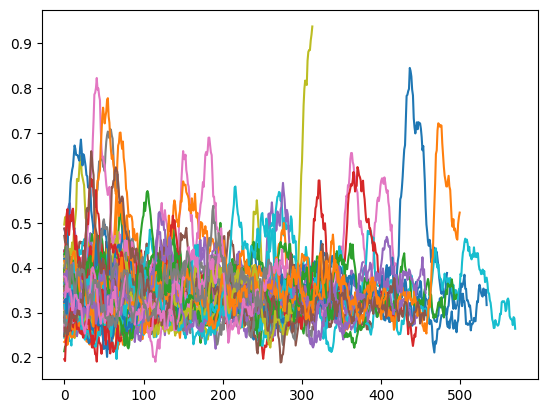

In [189]:
plt.plot(dff_by_trial_smooth[np.argmax(svc.coef_)].T)
plt.show()

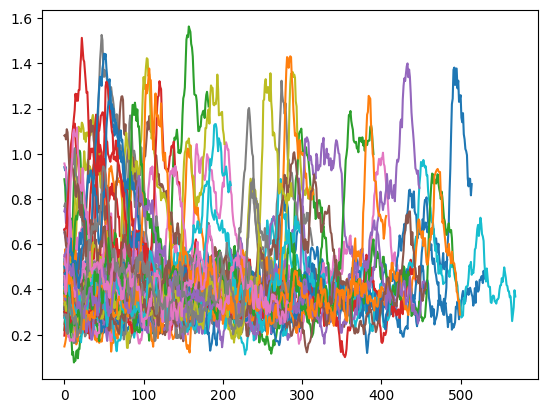

In [191]:
plt.plot(dff_by_trial_smooth[new_index].T)
plt.show()